In [126]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    def forward(self, input):
        pass
    def backward(self, output_gradient):
        pass
    def update(self, learning_rate,batch_size):
        pass



In [127]:
import numpy as np

class Dense(Layer):
    
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
        self.weights_gradient = np.zeros(self.weights.shape)
        self.bias_gradient = np.zeros(self.bias.shape)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias
    
    def backward(self, output_gradient):

        self.weights_gradient += np.dot(output_gradient,self.input.T) + 2 * 0.01 * self.weights#to add regularization, add the derivative of the regularization term here ( + 2*lambda*weights)
        self.bias_gradient += output_gradient
        input_gradient = np.dot(self.weights.T, output_gradient)
        
        return input_gradient
    
    def update(self, learning_rate,batch_size):
        self.weights -= learning_rate*(self.weights_gradient/batch_size)
        self.bias -= learning_rate*(self.bias_gradient/batch_size)
        self.weights_gradient = np.zeros(self.weights.shape)
        self.bias_gradient = np.zeros(self.bias.shape)

In [128]:
class Activation(Layer):

    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self,output_gradient):
        return np.multiply(output_gradient, self.activation_prime(self.input))


class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)


class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)
        

In [129]:
import numpy as np

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

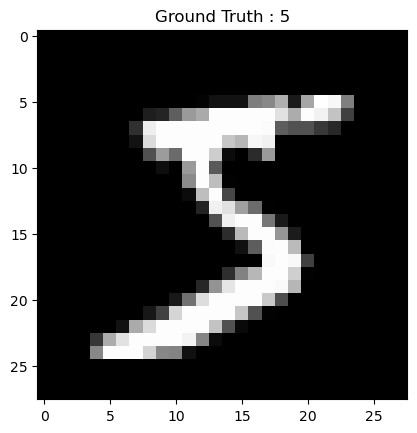

(60000, 784)
1.0
(60000, 10)


In [130]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
#reshape to 1D array
train_images = train_images.reshape(60000,784)
test_images = test_images.reshape(10000,784)

#display the first image in the training data
import matplotlib.pyplot as plt
plt.imshow(train_images[0].reshape(28,28),cmap='gray')
plt.title('Ground Truth : {}'.format(train_labels[0]))
plt.show()

print(train_images.shape)
#divide by 255 to normalize
train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255
print(np.max(train_images[0]))
#one hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

print(train_labels.shape)



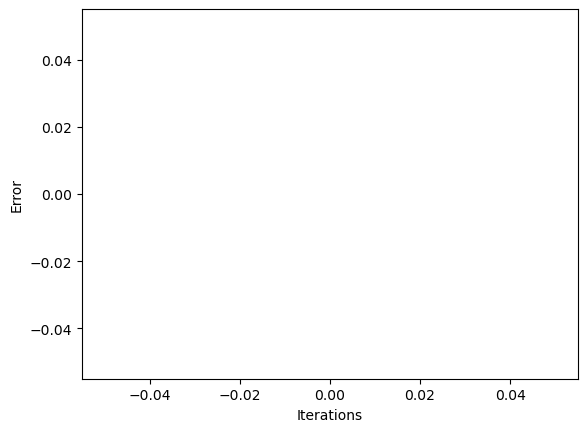

0.1144


In [131]:
model = [Dense(784, 128),
         Tanh(),
         Dense(128, 10),
         Tanh()]

batch_size = 60
epochs = 1
learning_rate = 0.01
n_batches = 60000/batch_size
error = []
for epoch in range(0):
    for index in range(60000):
        input = train_images[index].reshape(784,1)
        for layer in model:
            input = layer.forward(input)
        prediction = input
        
        output_gradient = mse_prime(train_labels[index].reshape(10,1), prediction)
        
        for layer in reversed(model):
            output_gradient = layer.backward(output_gradient)

        if index % batch_size == 0:
            for layer in model:
                layer.update(learning_rate,batch_size)
            error.append(mse(train_labels[index].reshape(10,1), prediction))

#graph error
import matplotlib.pyplot as plt
plt.plot(error)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

#test model
correct = 0
for index in range(10000):
    input = test_images[index].reshape(784,1)
    for layer in model:
        input = layer.forward(input)
    prediction = input
    if np.argmax(prediction) == np.argmax(test_labels[index]):
        correct += 1
print(correct/10000)


    

In [132]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, batch_size = 60, learning_rate = 0.01, verbose = True):
    costs = []
    for e in range(epochs):
        error = 0
        i=0
        for x, y in zip(x_train, y_train):
            i+=1
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad)
            if i%batch_size==0:
                for layer in network:
                    layer.update(learning_rate,batch_size)
        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")
        costs.append(error)
    return costs


In [133]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y = np_utils.to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]


# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 1000)
x_test, y_test = preprocess_data(x_test, y_test, 200)

# neural network
network = [
    Dense(28 * 28, 40),
    Tanh(),
    Dense(40, 10),
    Tanh()
]

# train
costs = train(network, mse, mse_prime, x_train, y_train, epochs=500, batch_size = 1, learning_rate=0.1)

# plot costs
import matplotlib.pyplot as plt
plt.plot(costs)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# calculate error on test set
error = 0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    error += mse(y, output)
error /= len(x_test)
print("error:", error)


# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))


1/500, error=0.5179493549181836
2/500, error=0.07264304756277991
3/500, error=0.0652357950207267
4/500, error=0.0643306195928427
5/500, error=0.06365607381930635
6/500, error=0.06305440935465496
7/500, error=0.06250257964139816
8/500, error=0.06199559991402083
9/500, error=0.061537098742961586
10/500, error=0.06114468734228409
11/500, error=0.06083725347701892
12/500, error=0.060604583310890726
13/500, error=0.060426063166766006


KeyboardInterrupt: 